<b>
Raktim Dey(MDS202132)
</br>
Sucheta Jhunjhunwala(MDS202151)</b>

<h1><b>Question 1</b></h1>

<b>Installing dependencies</b>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.autograd import Variable

from PIL import Image
from IPython.display import display
import cv2


import glob
import os
import random
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [ ]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x


# Display images, n=max number of images to show
def display_images(in_raw, out_raw, n=1):
    out_raw = out_raw[:n]
    if in_raw is not None:
        in_raw = in_raw[:n]
        in_pic = to_img(in_raw.cpu().data).view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.imshow(in_pic[i])
            plt.title("Original image")
            plt.axis('off')
    out_pic = to_img(out_raw.cpu().data).view(-1, 28, 28)
    plt.figure(figsize=(18, 6))
    for i in range(n):   
        plt.subplot(1,n,i+1)
        plt.imshow(out_pic[i])
        plt.title("Generated image")
        plt.axis('off')
    plt.show()

In [ ]:
#Normalise images
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


#Import data
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True, transform=img_transform),
    batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



<h3><b>Creating the Variational Autoencoder</b></h3>

In [ ]:
class VAE(nn.Module):
    def __init__(self, d=30):
        super().__init__()
        self.d = d #latent dimension
        
        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Tanh()
        )

    def sampler(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.sampler(mu, logvar)
        return self.decoder(z), mu, logvar
    
    def generate(self, N=10):
        z = torch.randn((N, self.d)).to(device)
        gen_img = self.decoder(z)
        return gen_img

In [ ]:
#Defining the loss function
def loss_function(x_hat, x, mu, logvar, beta=1):
    recon_loss = nn.functional.mse_loss(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    
    #KL Divergence is the added regularisation term
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    return recon_loss + beta * KLD



<b>Train the model</b>

In [ ]:
model = VAE().to(device)

# Setting the optimiser
learning_rate = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

epochs = 50
codes = dict(mu=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['mu'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')


====> Test set loss: 1230.6474
====> Epoch: 1 Average loss: 111.9854
====> Test set loss: 586.9405
====> Epoch: 2 Average loss: 78.1434
====> Test set loss: 568.6666
====> Epoch: 3 Average loss: 72.6804
====> Test set loss: 565.2318
====> Epoch: 4 Average loss: 69.9135
====> Test set loss: 567.0871
====> Epoch: 5 Average loss: 68.2125
====> Test set loss: 562.3963
====> Epoch: 6 Average loss: 67.0358
====> Test set loss: 562.3974
====> Epoch: 7 Average loss: 66.0617
====> Test set loss: 565.0800
====> Epoch: 8 Average loss: 65.3037
====> Test set loss: 562.6995
====> Epoch: 9 Average loss: 64.6328
====> Test set loss: 563.9845
====> Epoch: 10 Average loss: 64.1154
====> Test set loss: 558.6892
====> Epoch: 11 Average loss: 63.6831
====> Test set loss: 563.7967
====> Epoch: 12 Average loss: 63.2151
====> Test set loss: 566.1225
====> Epoch: 13 Average loss: 62.8010
====> Test set loss: 564.1723
====> Epoch: 14 Average loss: 62.4855
====> Test set loss: 561.7963
====> Epoch: 15 Average l

<h1><b>Random samples from latent space</b></h1>

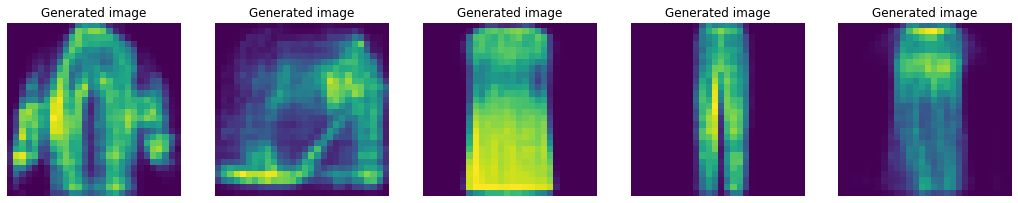

In [ ]:
N=5
display_images(None, model.generate(N), N)

<h1><b>Transitions between two images</b></h1>

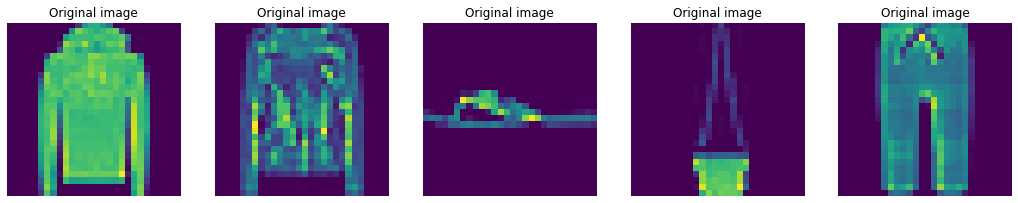

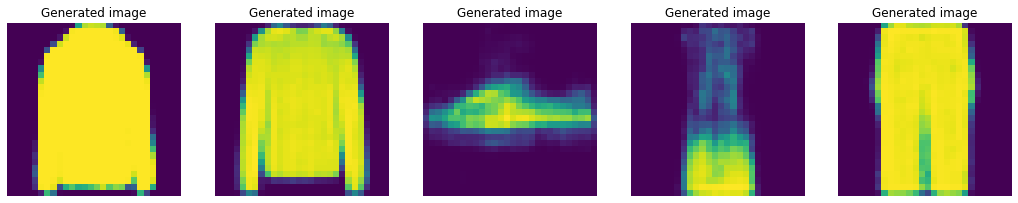

In [ ]:
display_images(x, x_hat, 5)

<h1><b>Question 2</b></h1>

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True, transform=img_transform),
    batch_size=224, shuffle=True)



In [ ]:
transform_img = transforms.Compose([
        transforms.Resize(28),  
        transforms.CenterCrop(28),
        transforms.ToTensor()
    ])

<b>Visualise the dataset</b>

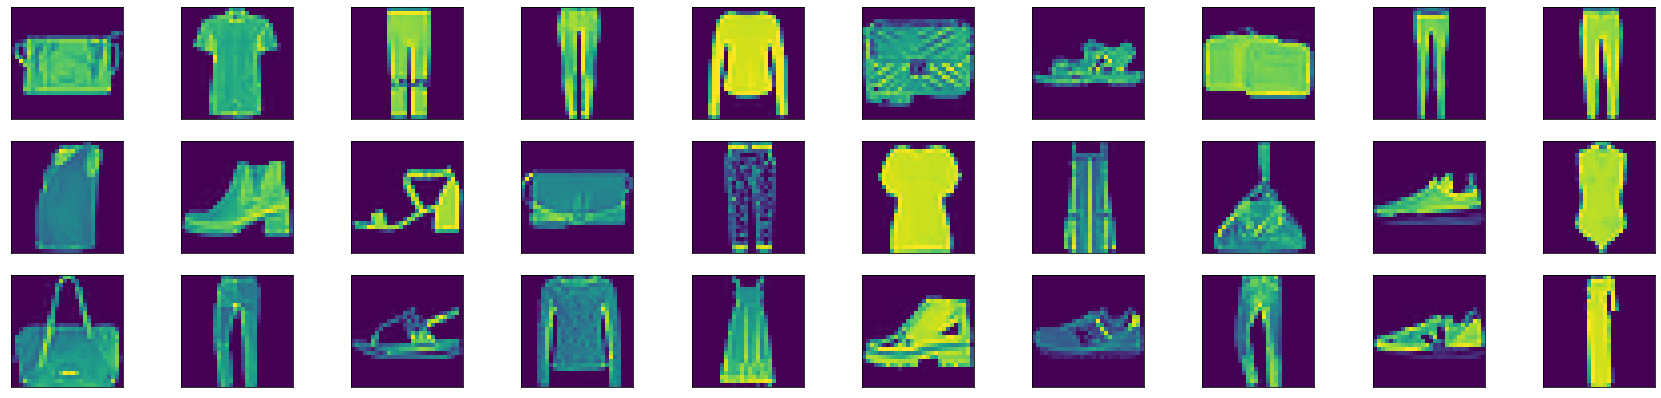

In [ ]:
dataiter = iter(train_loader)
img, _ = dataiter.next() # _ for labels, Dataloader sends labels automatically as defined in Dataloader class.
#However we don't need labels neither we assigned one :p so we put _ 
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(30, 7))
plot_size=30 # gonna plot 30 images only
for idx in np.arange(plot_size):
    ax = fig.add_subplot(3, plot_size/3, idx+1, xticks=[], yticks=[])
    npimg = img[idx].numpy()
    plt.imshow(npimg[0])

<b>Building the Discriminator</b>

In [ ]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding)
    
    #appending convolutional layer
    layers.append(conv_layer)

    #appending batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initializing the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer based on which we will create the  next ones where next  layer depth = 2 * previous layer depth
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        
        self.conv1 = conv(1, conv_dim, batch_norm=False)  
        self.conv2 = conv(conv_dim, conv_dim*2)           
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        self.fc = nn.Linear(conv_dim*4, 1)

    def forward(self, x):

        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        x = x.view(-1, self.conv_dim*4)
        
        x = self.fc(x)
        
        
        return x

<b>Building the Generator</b>

In [ ]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []
    
    # append transpose conv layer -- we are not using bias terms in conv layers
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))
    
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*2*7*7)
        # complete init function
        
        self.de_conv2 = deconv(conv_dim*2, conv_dim)
        self.de_conv3 = deconv(conv_dim, 1, 4, batch_norm=False )
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):

        # define feedforward behavior
        x = self.fc(x)
        x = self.dropout(x)
        
        x = x.view(-1, self.conv_dim*2, 7, 7)
        
        x = F.relu(self.de_conv2(x))
        x = self.de_conv3(x)
        x = F.tanh(x)
        
        
        return x

In [ ]:
def weights_init_normal(m):
    """
    :param m: A module or layer in a network    
    """
    # like `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    #  initial weights to convolutional and linear layers
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal(m.weight.data, 0.0, 0.2)
        
    if hasattr(m, 'bias') and m.bias is not None:
        nn.init.constant(m.bias.data, 0.0)

In [ ]:
#Output channels for the discriminator
d_conv_dim = 56

#Output channels for the generator
g_conv_dim = 224

#Dimension of the latent space
z_size = 100


# building discriminator and generator from the classes defined above
discriminator = Discriminator(d_conv_dim)
generator = Generator(z_size=z_size, conv_dim=g_conv_dim)

# initialize model weights
discriminator.apply(weights_init_normal)
generator.apply(weights_init_normal)

print("done")

done


In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
print(discriminator)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(56, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(112, 224, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=224, out_features=1, bias=True)
)


In [ ]:
print(generator)

Generator(
  (fc): Linear(in_features=100, out_features=21952, bias=True)
  (de_conv2): Sequential(
    (0): ConvTranspose2d(448, 224, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv3): Sequential(
    (0): ConvTranspose2d(224, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
lr = 0.0001 #learning rate
# optimizers for the discriminator D and generator G
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr) # for discriminator
generator_optimizer = torch.optim.Adam(generator.parameters(), lr)

In [ ]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
    
    if use_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if use_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [ ]:
def scale_images(x, max = 1.00 , min = -1.00):
    x = x * (max - min) + min
    return x

In [ ]:
def train(D, G, n_epochs, train_on_gpu, print_every=500):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(train_loader):

            batch_size = real_images.size(0)

            # Train the discriminator on real and fake images
            discriminator_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            discriminator_optimizer.step()     

            # 2. Train the generator with an adversarial loss
            generator_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            D_fake = D(fake_images)
            
            g_loss = real_loss(D_fake)
        
            g_loss.backward()
            generator_optimizer.step()
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))



        G.eval() # for generating samples
        samples_z = G(fixed_z)
        sample_images = samples_z.view(samples_z.size(0), 28, 28).unsqueeze(1).data.cpu()
        grid = make_grid(sample_images, nrow=4, normalize=True).permute(1,2,0).numpy()
        plt.imshow(grid)
        plt.show()
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Epoch [    1/   50] | d_loss: 2.1618 | g_loss: 0.5885


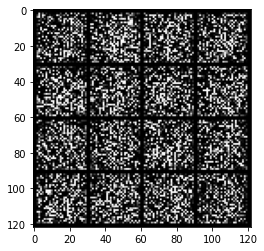

Epoch [    2/   50] | d_loss: 0.2568 | g_loss: 2.6480


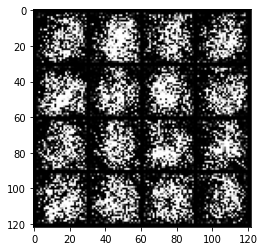

Epoch [    3/   50] | d_loss: 0.1404 | g_loss: 3.3555


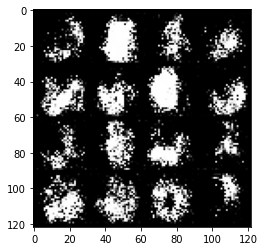

Epoch [    4/   50] | d_loss: 0.1112 | g_loss: 3.7221


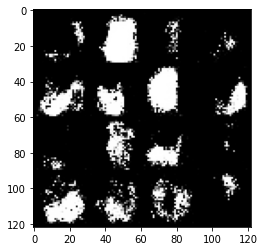

Epoch [    5/   50] | d_loss: 0.0425 | g_loss: 4.4511


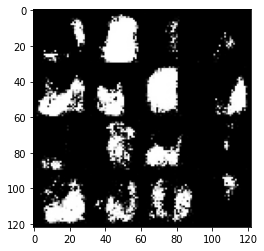

Epoch [    6/   50] | d_loss: 0.0326 | g_loss: 5.3978


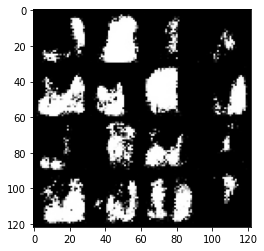

Epoch [    7/   50] | d_loss: 0.0186 | g_loss: 5.5755


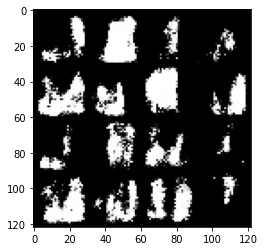

Epoch [    8/   50] | d_loss: 0.0193 | g_loss: 5.9596


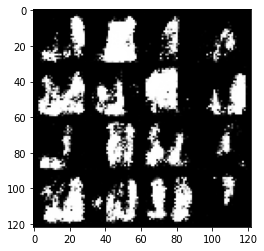

Epoch [    9/   50] | d_loss: 0.0199 | g_loss: 6.0265


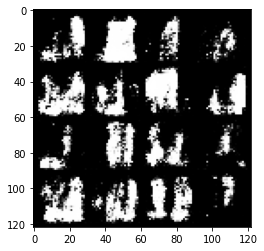

Epoch [   10/   50] | d_loss: 0.0065 | g_loss: 6.5413


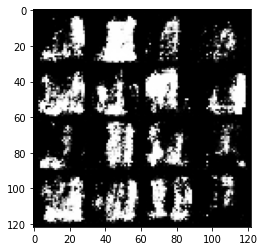

Epoch [   11/   50] | d_loss: 0.0077 | g_loss: 6.8330


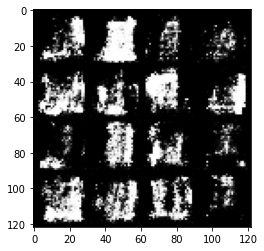

Epoch [   12/   50] | d_loss: 0.0107 | g_loss: 6.8102


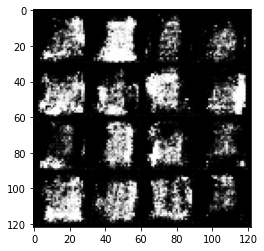

Epoch [   13/   50] | d_loss: 0.0213 | g_loss: 6.1450


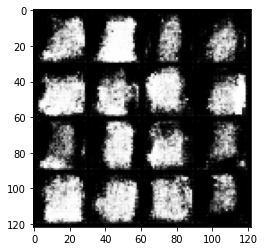

Epoch [   14/   50] | d_loss: 0.0560 | g_loss: 6.2107


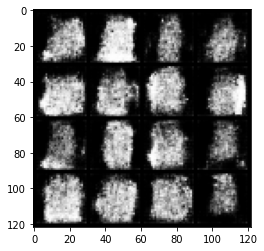

Epoch [   15/   50] | d_loss: 0.1077 | g_loss: 4.8227


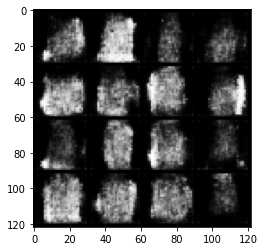

Epoch [   16/   50] | d_loss: 0.0389 | g_loss: 4.8960


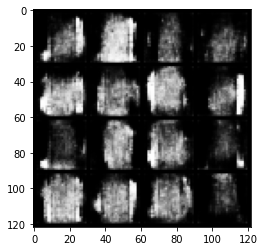

Epoch [   17/   50] | d_loss: 0.0217 | g_loss: 5.1174


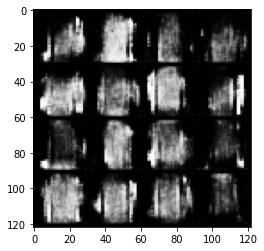

Epoch [   18/   50] | d_loss: 0.0236 | g_loss: 6.2986


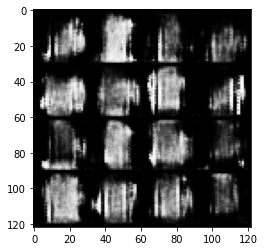

Epoch [   19/   50] | d_loss: 0.0164 | g_loss: 6.6168


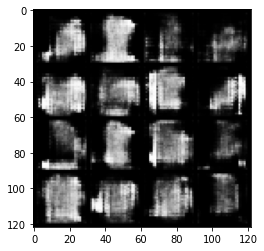

Epoch [   20/   50] | d_loss: 0.0230 | g_loss: 6.2562


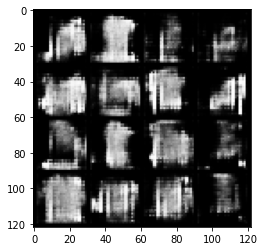

Epoch [   21/   50] | d_loss: 0.0202 | g_loss: 6.6145


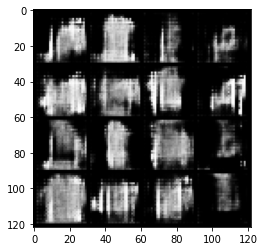

Epoch [   22/   50] | d_loss: 0.0114 | g_loss: 6.5041


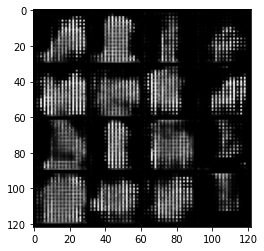

Epoch [   23/   50] | d_loss: 0.0009 | g_loss: 10.2319


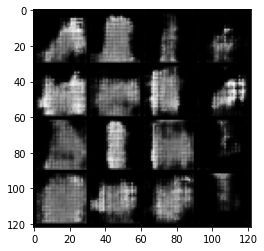

Epoch [   24/   50] | d_loss: 0.0561 | g_loss: 6.0396


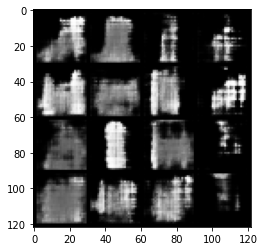

Epoch [   25/   50] | d_loss: 0.0879 | g_loss: 4.8511


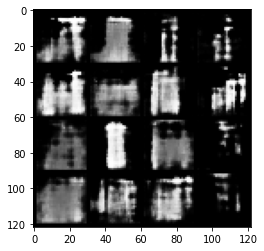

Epoch [   26/   50] | d_loss: 0.1359 | g_loss: 4.4292


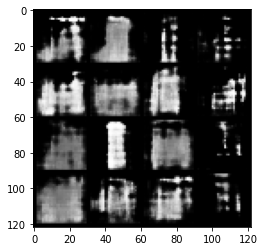

Epoch [   27/   50] | d_loss: 0.0906 | g_loss: 4.6372


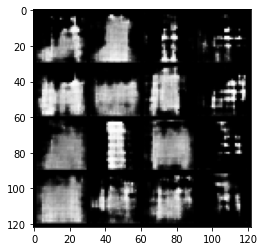

Epoch [   28/   50] | d_loss: 0.0681 | g_loss: 4.8100


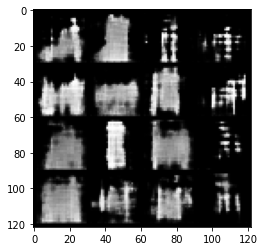

Epoch [   29/   50] | d_loss: 0.0616 | g_loss: 5.0482


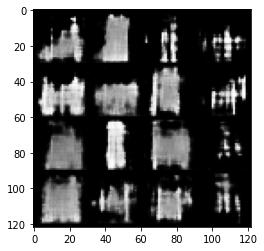

Epoch [   30/   50] | d_loss: 0.0641 | g_loss: 4.7378


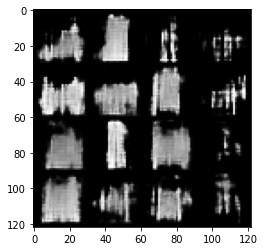

Epoch [   31/   50] | d_loss: 0.0801 | g_loss: 5.0547


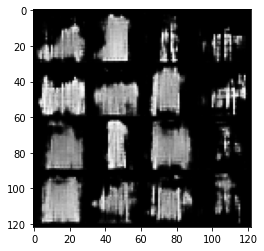

Epoch [   32/   50] | d_loss: 0.0856 | g_loss: 5.0308


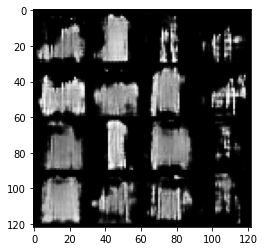

Epoch [   33/   50] | d_loss: 0.0662 | g_loss: 4.6203


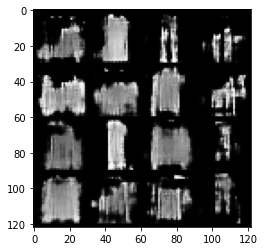

Epoch [   34/   50] | d_loss: 0.0498 | g_loss: 5.3963


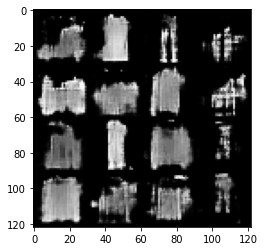

Epoch [   35/   50] | d_loss: 0.0724 | g_loss: 5.6954


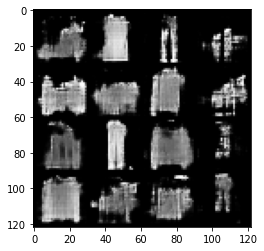

Epoch [   36/   50] | d_loss: 0.0947 | g_loss: 4.1424


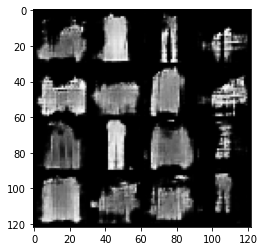

Epoch [   37/   50] | d_loss: 0.0809 | g_loss: 4.7488


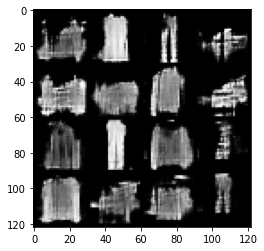

Epoch [   38/   50] | d_loss: 0.0536 | g_loss: 5.3369


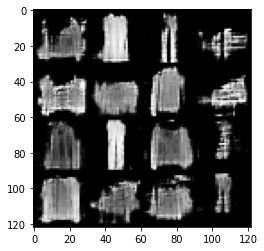

Epoch [   39/   50] | d_loss: 0.1476 | g_loss: 5.4143


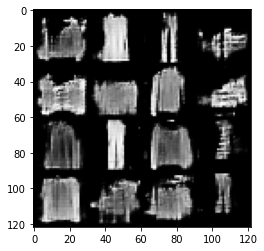

Epoch [   40/   50] | d_loss: 0.1040 | g_loss: 5.1158


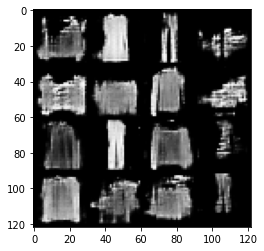

Epoch [   41/   50] | d_loss: 0.1186 | g_loss: 5.5251


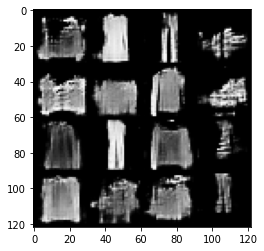

Epoch [   42/   50] | d_loss: 0.1232 | g_loss: 3.9872


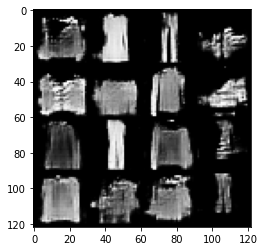

Epoch [   43/   50] | d_loss: 0.0989 | g_loss: 4.5508


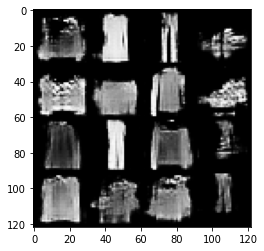

Epoch [   44/   50] | d_loss: 0.2060 | g_loss: 4.7938


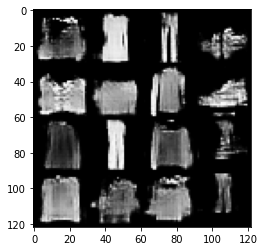

Epoch [   45/   50] | d_loss: 0.1146 | g_loss: 3.8830


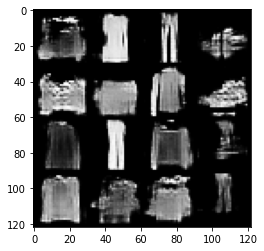

Epoch [   46/   50] | d_loss: 0.1763 | g_loss: 3.8086


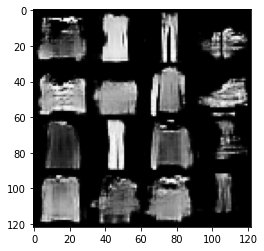

Epoch [   47/   50] | d_loss: 0.2785 | g_loss: 3.6179


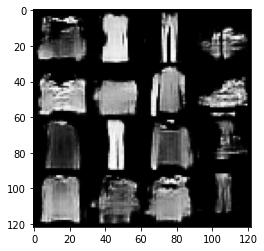

Epoch [   48/   50] | d_loss: 0.2123 | g_loss: 3.5078


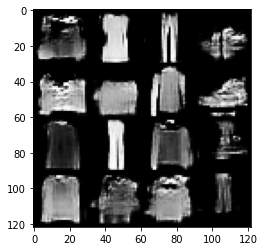

Epoch [   49/   50] | d_loss: 0.2418 | g_loss: 4.0421


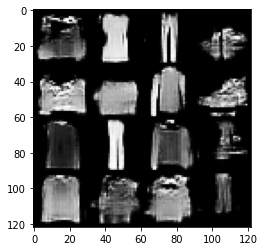

Epoch [   50/   50] | d_loss: 0.1751 | g_loss: 3.2629


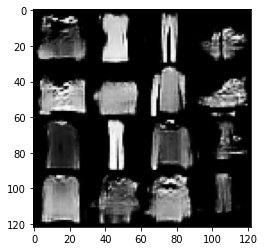

In [ ]:
n_epochs = 50
losses = train(discriminator, generator, n_epochs=n_epochs, train_on_gpu = use_gpu)

In [ ]:
#Save the GAN and its parameters
PATH = "model.pt"

torch.save({
            'modelA_state_dict': discriminator.state_dict(),
            'modelB_state_dict': generator.state_dict(),
            'optimizerA_state_dict': discriminator_optimizer.state_dict(),
            'optimizerB_state_dict': generator_optimizer.state_dict(),
            }, PATH)

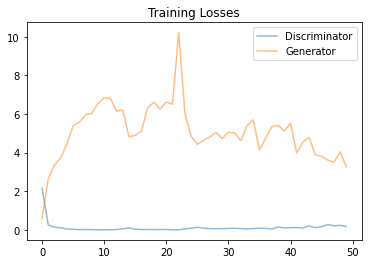

In [ ]:
#Plotting Generator loss v Discriminator loss
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

<h3><b>Generating five random codewords</b></h3>

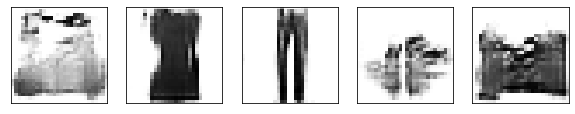

In [ ]:
fig,ax=plt.subplots(1,5,figsize=(10,20),squeeze=False)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
imgs=samples[-1]
imgs = imgs.detach().cpu().numpy()
for i in range(5):
  img=imgs[i]
  img = np.transpose(img, (1,2,0))
  img = ((img + 1)*255 / (2)).astype(np.uint8)
  img=img.reshape(1,28,28)
  ax[0][i].imshow(img[0],cmap="binary")
  
